In [2]:
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import time

In [3]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [4]:
EUR_USD = yf.download("EURUSD=X", start="2021-02-22", end="2021-02-26", interval="1m")
EUR_USD.shape

[*********************100%***********************]  1 of 1 completed


(5610, 6)

In [5]:
# EUR_USD.to_csv('EUR_USD.csv')

In [6]:
EUR_USD = pd.read_csv('EUR_USD.csv')
# EUR_USD['Datetime'] = pd.to_datetime(EUR_USD['Datetime'])
EUR_USD['Datetime'] = pd.to_datetime(EUR_USD.Datetime).dt.tz_localize(None)
EUR_USD.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2021-02-22 00:00:00,1.212856,1.212856,1.212856,1.212856,1.212856,0
1,2021-02-22 00:01:00,1.212709,1.212709,1.212709,1.212709,1.212709,0
2,2021-02-22 00:02:00,1.212856,1.212856,1.212856,1.212856,1.212856,0
3,2021-02-22 00:03:00,1.213003,1.213003,1.213003,1.213003,1.213003,0
4,2021-02-22 00:04:00,1.212562,1.212562,1.212562,1.212562,1.212562,0


In [7]:
EUR_USD.dtypes

Datetime     datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

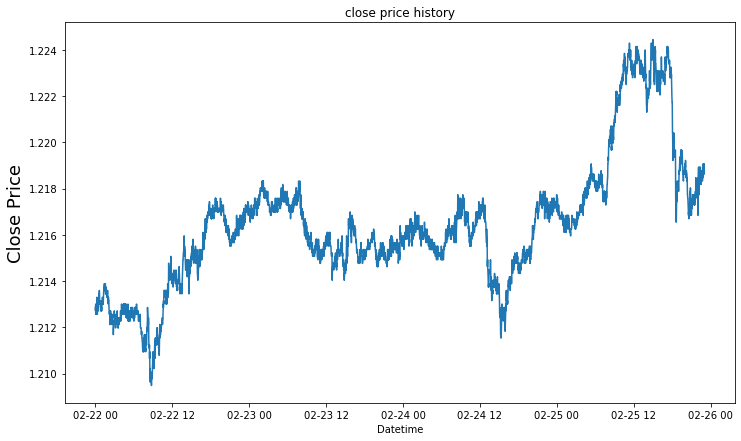

In [8]:
plt.rcParams['figure.figsize'] = [12, 7]
plt.title('close price history')
plt.plot(EUR_USD['Datetime'], EUR_USD['Close'])
plt.xlabel('Datetime')
plt.ylabel('Close Price', fontsize = 18)
plt.show()

In [9]:
#tomar solo los valores de close
data = EUR_USD.filter(['Close'])
# convertir el dataframe a un numpy array
dataset = data.values
#Coger el 80% de las filas para el modelo de entrenamiento
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

4488

In [10]:
#Escalar los datos
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.22557044],
       [0.21573566],
       [0.22557044],
       ...,
       [0.61094419],
       [0.62087461],
       [0.64074343]])

In [11]:
# Crear el training dataset con los datos escalados
train_data =scaled_data[0:training_data_len, :]
# dividir la data en 2 datasets
x_train = [] # x_train es los independing training features
y_train = [] # y_train es la variable dependiente objetivo

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) #append the past 60 (pos 0 a 59) values to our x_train 
    y_train.append(train_data[i, 0]) # va a contener el valor 61 en posicion 60
    if i<= 60:
        print(x_train)
        print(y_train)
        print()

[array([0.22557044, 0.21573566, 0.22557044, 0.23540523, 0.20590884,
       0.22557044, 0.21573566, 0.20590884, 0.21573566, 0.20590884,
       0.23540523, 0.23540523, 0.21573566, 0.22557044, 0.25508277,
       0.23540523, 0.23540523, 0.21573566, 0.20590884, 0.21573566,
       0.22557044, 0.22557044, 0.22557044, 0.22557044, 0.22557044,
       0.24524798, 0.21573566, 0.21573566, 0.21573566, 0.22557044,
       0.23540523, 0.24524798, 0.24524798, 0.26492552, 0.25508277,
       0.26492552, 0.24524798, 0.27477625, 0.26492552, 0.25508277,
       0.24524798, 0.23540523, 0.24524798, 0.23540523, 0.24524798,
       0.23540523, 0.23540523, 0.24524798, 0.22557044, 0.22557044,
       0.22557044, 0.21573566, 0.24524798, 0.21573566, 0.23540523,
       0.24524798, 0.22557044, 0.22557044, 0.22557044, 0.21573566])]
[0.2255704414495483]



In [12]:
#Convertir el x_train y y_train a numpy arrays para poder entrenar el modelo LSTM
x_train, y_train = np.array(x_train), np.array(y_train)

In [13]:
#reshape la data el x_train(4428, 60) tiene 2 dimensiones
# Esto se hace porque la red LSTM espera recibir un input de 3 dimensiones:
# Necesario: 1. El número de muestras, 2. número de minutos seleccionados, 3. número de output(closeprice)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
#Nueva forma
x_train.shape

(4428, 60, 1)

In [15]:
#Construcción delmodelo LSTM
model = Sequential()
# Se utilizan 50 neuronas, True porque va a haber más LSTM layers
# Como es el primer layer, se le añade el número de minutos seleccionados y el nº de outputs (60,1)
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# Otro layer con 50 neuronas
model.add(LSTM(50, return_sequences =False))
#Se añade un dense layer con 25 neuronas
model.add(Dense(25))
#Se añade otro dense layer con 1 neurona
model.add(Dense(1))

In [16]:
#Compile the model
# Se utiliza un optimizador para mejorar la función de perdida(loss function)
model.compile(optimizer='adam', loss='mean_squared_error')
#loss function mide como de bien lo ha hecho el modelo en el entrenamiento

In [17]:
#Entrenamos el modelo
model.fit(x_train, y_train, batch_size = 1, epochs=1)

4428/4428 [==============================] - 75s 16ms/step - loss: 0.0014


In [67]:
#Ahora procedemmos a crear el testing dataset
#Creamos un array que contiene los valores esclados de (4428-60) a 5610
test_data = scaled_data[training_data_len - 60: , :]
#Creamos otra vez los dataset x e y para test 
x_test = [] #lista vacia
y_test = dataset[training_data_len:, :] 
# y_test son los valores que queremos que nuestro modelo prediga (no estan escalados)
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [68]:
#Se convierten los datos en un numpy array
x_test = np.array(x_test)

In [69]:
#Reshape a la data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [70]:
x_test.shape

(1122, 60, 1)

In [60]:
#Conseguir los valores predichos
predictions = model.predict(x_test)
predictions =scaler.inverse_transform(predictions) #esto se hace para desescalar los valores

In [61]:
# Root mean square error (RMSE)
#rms_error = np.sqrt(mean_squared_error(predictions,y_test.fittedvalues))
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print("El rmse es de:", rmse)
#Es bastante bueno, un valor de 0 indica que predice exactamente los valores dados
# mide la cantidad de error que hay entre dos conjuntos de datos. 
# En otras palabras, compara un valor predicho y un valor observado o conocido.

El rmse es de: 0.0008013924175405135


<ipython-input-62-46599c9a15dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


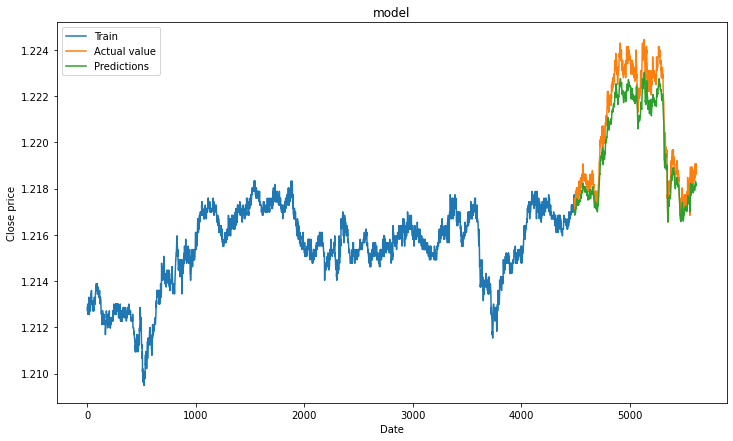

In [62]:
train = data[:training_data_len]
valid =data[training_data_len:]
valid['Predictions'] = predictions
plt.title('model')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual value', 'Predictions'])
plt.show()

In [63]:
valid

,Close,Predictions
4488,1.217285,1.217058
4489,1.217582,1.217005
4490,1.216841,1.217047
4491,1.217434,1.216866
4492,1.217285,1.216873
...,...,...
5605,1.218769,1.218252
5606,1.218621,1.218224
5607,1.218621,1.218163
5608,1.218769,1.218116


### para 1 día

In [ ]:
EUR_USD = yf.download("EURUSD=X", start="2021-02-22", end="2021-02-22", interval="1m")
EUR_USD.shape

In [ ]:
EUR_USD.to_csv('EUR_USD.csv')